In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
raw = sc.read_h5ad("Raw_GSE227991.h5ad")
#merge = sc.read_h5ad("Merge_data/Merge_data_bbknn(GSE165080,GSE149689,GSE174188).h5ad")
#healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")

In [ ]:
merge

In [ ]:
common_genes = merge.var.index.intersection(raw.var.index)
common_genes

In [ ]:
len(common_genes)

In [ ]:
#del healthy
#import gc
#gc.collect()

In [ ]:
# 只保留top200
raw = raw[:, common_genes]
raw

In [ ]:
raw.var_names_make_unique()
raw.obs_names_make_unique()
sc.pp.filter_cells(raw, min_genes=200)
sc.pp.filter_genes(raw, min_cells=3)

In [ ]:
raw

In [ ]:
raw.write_h5ad("GSE227991_healthy_make_unique.h5ad")

# After annotation

In [3]:
#raw = sc.read_h5ad("Merge_data/Merge_data_20_people_make_unique.h5ad")
#annotation = sc.read_h5ad("Merge_data/Raw_GSE227991_post.h5ad")


combine = sc.read_h5ad("Merge_data/raw_GSE165080_GSE149689_GSE227991_make_unique.h5ad")
annotation_merge = sc.read_h5ad("Merge_data/Raw_GSE165080_GSE149689_GSE227991_post.h5ad")

In [4]:
combine

AnnData object with n_obs × n_vars = 95955 × 10619
    obs: 'Age', 'Gender', 'BioSample', 'n_genes'

In [5]:
annotation_merge

AnnData object with n_obs × n_vars = 95955 × 10619
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_refAssay', 'nFeature_refAssay', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score'
    var: 'features', 'RNA_features'
    layers: 'RNA'

In [6]:
combine.obs["cell_type_l1"] = annotation_merge.obs["predicted.celltype.l1"]
combine.obs["cell_type_l2"] = annotation_merge.obs["predicted.celltype.l2"]
combine.obs["cell_type_l3"] = annotation_merge.obs["predicted.celltype.l3"]
combine

AnnData object with n_obs × n_vars = 95955 × 10619
    obs: 'Age', 'Gender', 'BioSample', 'n_genes', 'cell_type_l1', 'cell_type_l2', 'cell_type_l3'

In [7]:
combine.var['mt'] = combine.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(combine, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [16]:
combine

AnnData object with n_obs × n_vars = 95261 × 10619
    obs: 'Age', 'Gender', 'BioSample', 'n_genes', 'cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

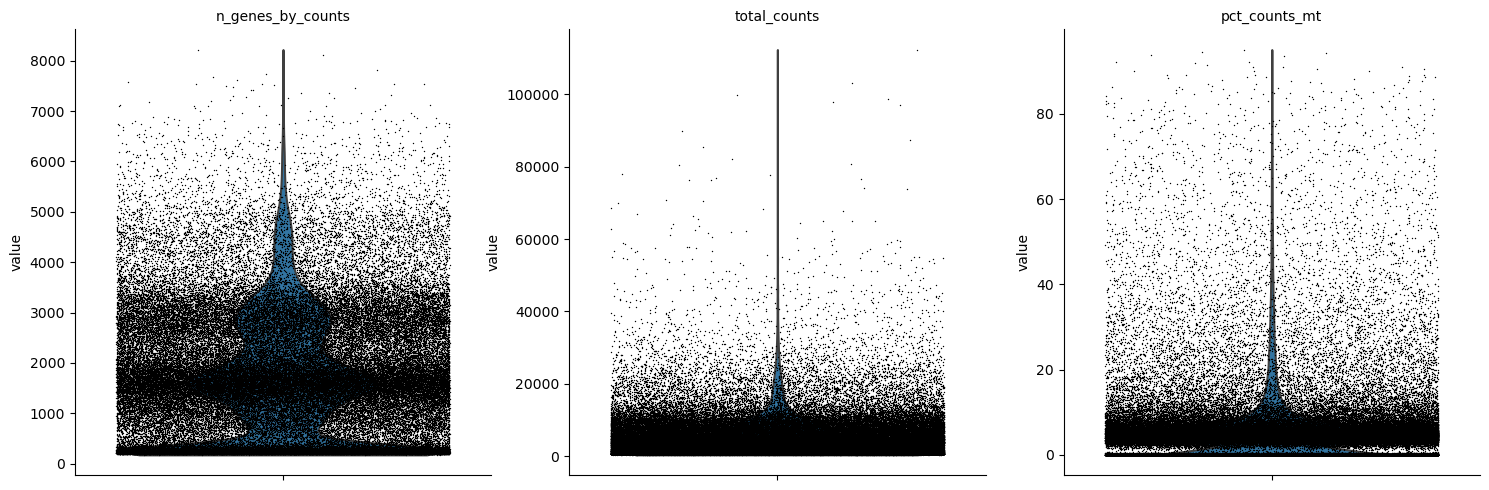

In [9]:
sc.pl.violin(combine, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [19]:
combine = combine[combine.obs.n_genes_by_counts < 7000, :]
combine = combine[combine.obs.pct_counts_mt < 60, :]
combine

View of AnnData object with n_obs × n_vars = 95261 × 10619
    obs: 'Age', 'Gender', 'BioSample', 'n_genes', 'cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

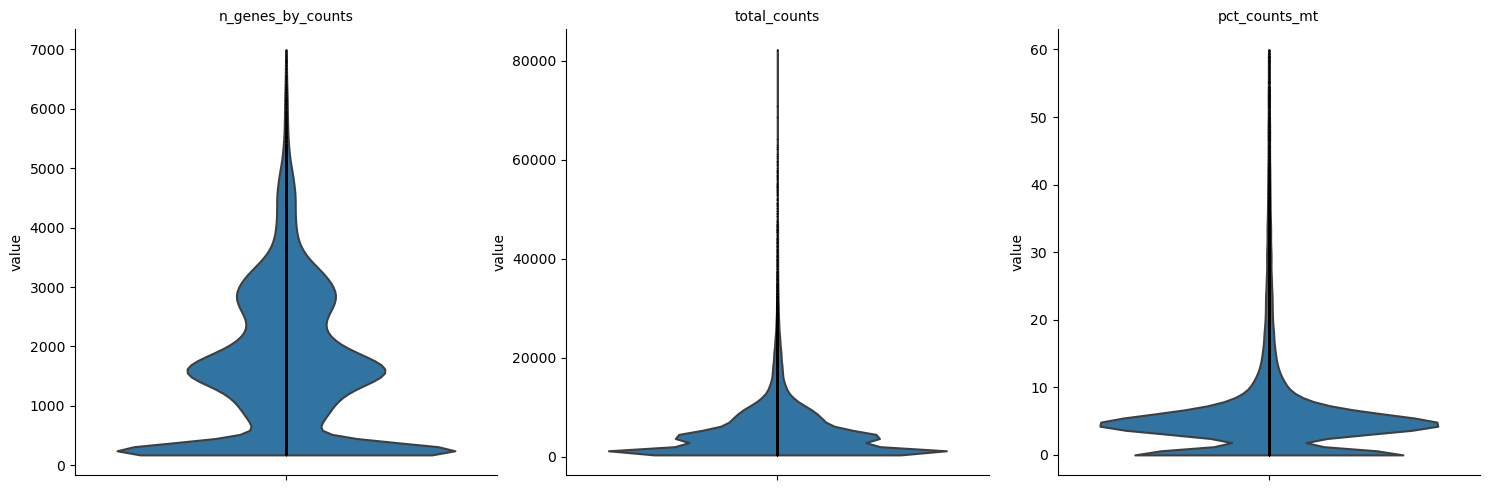

In [12]:
sc.pl.violin(combine, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0, multi_panel=True)

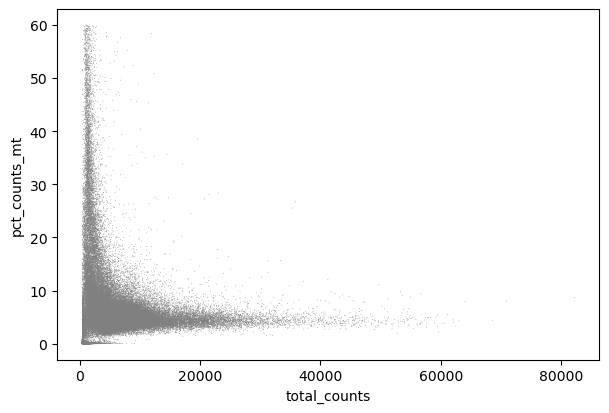

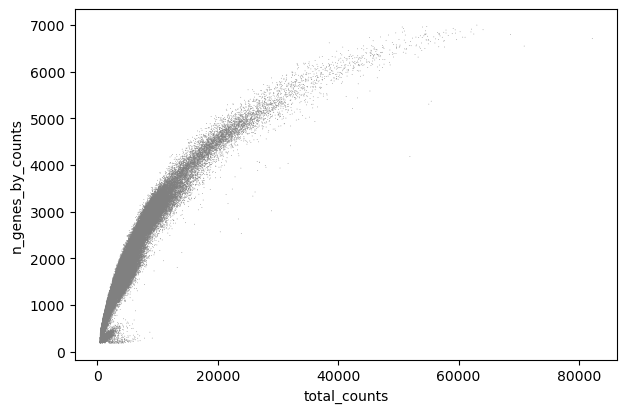

In [14]:
sc.pl.scatter(combine, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(combine, x='total_counts', y='n_genes_by_counts')

In [13]:
sc.pp.normalize_total(combine, target_sum=1e4)
sc.pp.log1p(combine)

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


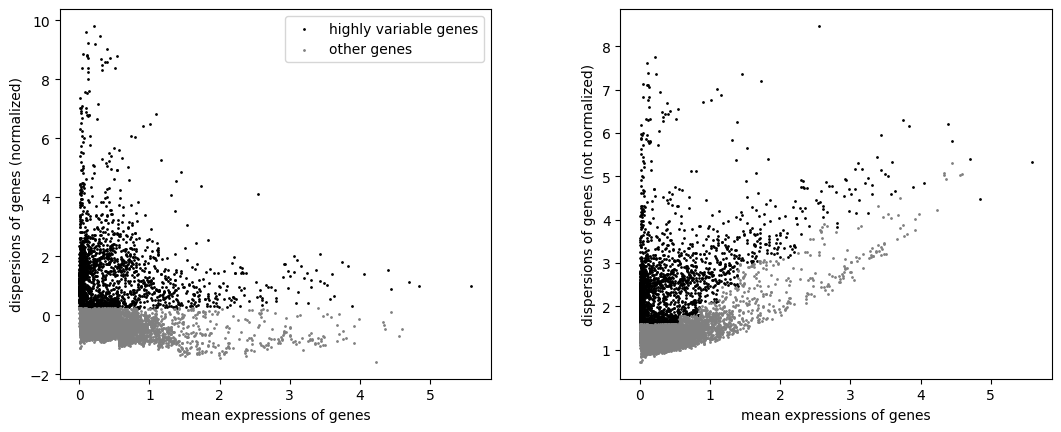

In [15]:
sc.pp.highly_variable_genes(combine, n_top_genes=2000)
sc.pl.highly_variable_genes(combine)

In [17]:
# linear regression out unwanted sources of variation
sc.pp.regress_out(combine, ['total_counts', 'pct_counts_mt'])

In [18]:
combine.X

array([[-0.05530676, -0.01742256, -0.19941448, ...,  0.1638903 ,
         0.51263785, -0.00239425],
       [-0.03899463, -0.00869498, -0.13701135, ...,  1.2982746 ,
         1.0843022 , -0.00215194],
       [-0.04561493, -0.01267491, -0.16368377, ...,  0.69932514,
         0.7422358 , -0.00235888],
       ...,
       [-0.02479172, -0.00444379, -0.0929696 , ..., -1.7232281 ,
        -0.03351075, -0.00277134],
       [-0.02417533, -0.00419131, -0.09084925, ..., -1.684278  ,
        -0.0320611 , -0.00278136],
       [-0.0238146 , -0.00401972, -0.08953508, ..., -1.6706109 ,
        -0.03120658, -0.00278132]], dtype=float32)

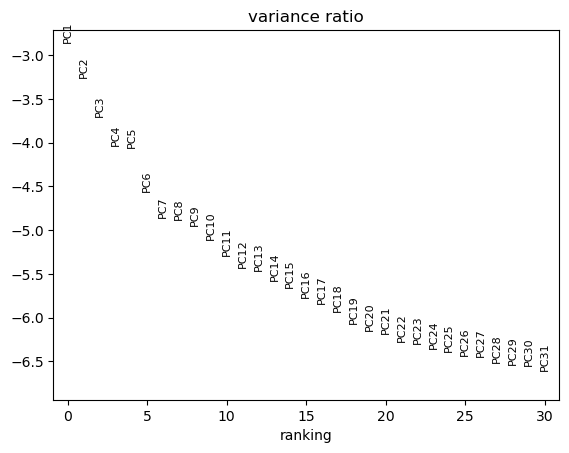

In [19]:
sc.pp.scale(combine, max_value=10)
sc.tl.pca(combine, svd_solver='arpack')
sc.pl.pca_variance_ratio(combine, log=True)

In [20]:
sc.pp.neighbors(combine, n_neighbors=10, n_pcs=40)
sc.tl.leiden(combine)

C:\ProgramData\anaconda3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\ProgramData\anaconda3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\ProgramData\anaconda3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

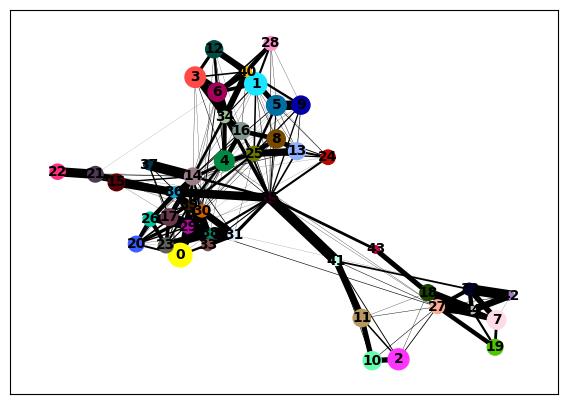

In [21]:
# default use leiden透過leiden去計算那個gene expression的部分去挑出最後的權重
#再多維的空間做hireachecal(階層的)挑選，clustering會越來越少，直到hirachical跟cluster一樣才會結束
sc.tl.paga(combine)
sc.pl.paga(combine)

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


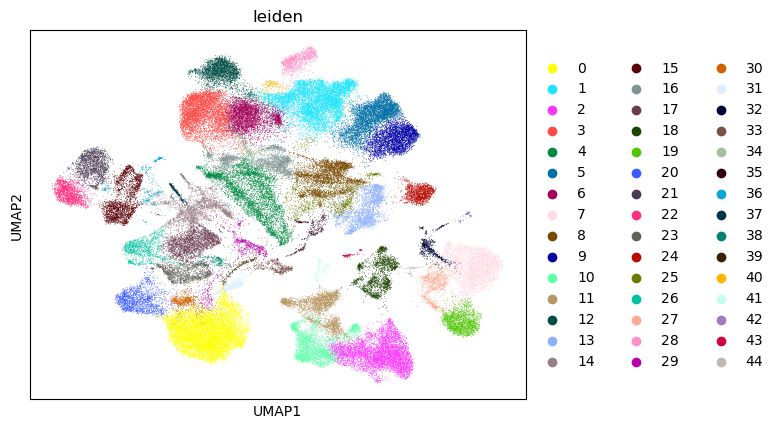

In [22]:
sc.tl.umap(combine, init_pos='paga')
sc.pl.umap(combine, color = "leiden")

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


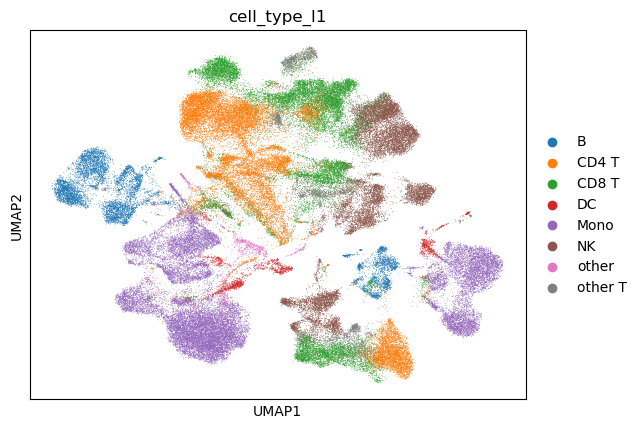

In [23]:
sc.pl.umap(combine, color = "cell_type_l1")

In [24]:
combine.obs

,Age,Gender,BioSample,n_genes,cell_type_l1,cell_type_l2,cell_type_l3,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCTGAGAGTTGGC-1,34,female,SAMN17379694,3734,Mono,CD14 Mono,CD14 Mono,3516,11692.0,529.0,4.524461,0
AAACCTGAGGGCTTGA-1,34,female,SAMN17379694,2001,other T,gdT,gdT_1,1894,4628.0,338.0,7.303370,28
AAACCTGCAAGCTGTT-1,34,female,SAMN17379694,2471,CD8 T,CD8 Naive,CD8 Naive,2312,7806.0,384.0,4.919293,12
AAACCTGCAATAAGCA-1,34,female,SAMN17379694,1487,NK,NK,NK_1,1412,2778.0,371.0,13.354932,5
AAACCTGCAATGTAAG-1,34,female,SAMN17379694,2423,CD8 T,CD8 TCM,CD8 TCM_1,2298,6596.0,550.0,8.338387,12
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGTGCACA-1-1,66,male,SAMN33864803,293,Mono,CD14 Mono,CD14 Mono,293,1149.0,0.0,0.000000,7
TTTGGTTAGGTTACCT-1,66,male,SAMN33864803,304,NK,NK,NK_4,304,898.0,2.0,0.222717,11
TTTGGTTCAGCATACT-1,66,male,SAMN33864803,263,NK,NK,NK_1,263,856.0,1.0,0.116822,10
TTTGTCAAGGAGCGAG-1,66,male,SAMN33864803,228,NK,NK,NK_1,228,644.0,0.0,0.000000,10


In [25]:
combine.write_h5ad("GSE16500800_GSE149689_GSE227991_highly_variable_genes.h5ad")

In [ ]:
raw_GSE165080 = sc.read_h5ad("Merge_data/Raw_GSE165080.h5ad")
raw_GSE149689 = sc.read_h5ad("Merge_data/Raw_GSE149689.h5ad")
raw_GSE227991 = sc.read_h5ad("Merge_data/Raw_GSE227991.h5ad")


In [ ]:
set(raw_GSE165080.obs.Age)

In [ ]:
set(raw_GSE149689.obs.Age)

In [ ]:
set(raw_GSE227991.obs.Age)

In [ ]:
sc.pl.umap(annotation, color = "predicted.celltype.l1")

In [ ]:
raw.obs.rename(columns={'predicted.celltype.l1': 'celltype_1', 'predicted.celltype.l2.score': 'celltype_2.score', 'predicted.celltype.l2': 'celltype_2', 'predicted.celltype.l3.score': 'celltype_3.score', 'predicted.celltype.l3': 'celltype_3'}, inplace=True)

In [ ]:
raw.raw = None

In [ ]:
raw.write_h5ad("Merge_data_annotation_0403.h5ad")

In [ ]:
raw.var.index
#.rename('new_index')